# Deep Learning Project 3: Jailbreaking Deep Models

Tasks 1–5 implemented with ResNet-34 and adversarial attacks.
Task 5 implemented with DenseNet-121.

In [1]:
# Upload and Prepare ImageNet Subset for Adversarial Attacks

# Step 1: Upload and unzip the dataset
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Upload TestDataSet.zip

with zipfile.ZipFile("TestDataSet.zip", 'r') as zip_ref:
    zip_ref.extractall("TestDataSet")

# Optional: Check path structure
for root, dirs, files in os.walk("TestDataSet"):
    print("Found folder:", root)
    break  # just top level

# Step 2: Setup environment
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 3: Load pre-trained ResNet-34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

# Step 4: Define transforms
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Step 5: Load dataset using ImageFolder
# Adjust path below if printed folder above shows deeper nesting
dataset_path = "TestDataSet/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset loaded with {len(dataset)} images across {len(dataset.classes)} classes.")


Saving TestDataSet.zip to TestDataSet.zip
Found folder: TestDataSet
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


Dataset loaded with 500 images across 100 classes.


In [2]:
from google.colab import files
import json

# Upload the labels_list.json file
uploaded = files.upload()

# Load the JSON file with label mappings
with open("labels_list.json", "r") as f:
    labels_list = json.load(f)

Saving labels_list.json to labels_list.json


In [3]:
# Create a mapping from ImageNet indices to class names
label_map = {}
for entry in labels_list:
    idx, name = entry.split(": ", 1)
    label_map[int(idx)] = name

In [4]:
# --- Step 3: Map ImageFolder label indices → true ImageNet indices ---
# dataset.class_to_idx = {'accordion': 0, 'airliner': 1, ..., 'zipper': 99}
# dataset.classes = ['accordion', 'airliner', ..., 'zipper']
folder_to_imagenet_idx = {
    dataset.class_to_idx[class_name]: int(entry.split(": ")[0])
    for entry, class_name in zip(labels_list, dataset.classes)
}

In [5]:
# Function to get the top-k predictions and check if the true label is among them
# --- Step 4: Define compute_accuracy function ---
def compute_accuracy(outputs, labels, folder_to_imagenet_idx, k=1):
    _, top_k_indices = torch.topk(outputs, k, dim=1)
    correct = 0
    for i, label in enumerate(labels):
        true_label = folder_to_imagenet_idx[label.item()]
        if true_label in top_k_indices[i]:
            correct += 1
    return correct / len(labels)

In [6]:
# --- Step 5: Evaluate the model on the test dataset ---
print("Evaluating model on test dataset...")
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        total += labels.size(0)

        top1_correct += compute_accuracy(outputs, labels, folder_to_imagenet_idx, k=1) * labels.size(0)
        top5_correct += compute_accuracy(outputs, labels, folder_to_imagenet_idx, k=5) * labels.size(0)

# --- Step 6: Report final accuracy ---
top1_accuracy = top1_correct / total
top5_accuracy = top5_correct / total

print(f"\nTop-1 Accuracy: {top1_accuracy:.4f} ({top1_correct:.0f}/{total})")
print(f"Top-5 Accuracy: {top5_accuracy:.4f} ({top5_correct:.0f}/{total})")

Evaluating model on test dataset...


100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


Top-1 Accuracy: 0.7600 (380/500)
Top-5 Accuracy: 0.9420 (471/500)


In [7]:
# --- Display Top-5 class names for the first image in the last batch ---
single_output = model(images[0].unsqueeze(0))
_, top5_indices = torch.topk(single_output, 5)
top5_indices = top5_indices.cpu().numpy()[0]
pred_class_names = [label_map.get(idx, 'unknown') for idx in top5_indices]

print("\nTop-5 Predictions for First Image:")
print("Indices:", top5_indices)
print("Class Names:", pred_class_names)



Top-5 Predictions for First Image:
Indices: [489 695 455 746 539]
Class Names: ['chainlink fence', 'unknown', 'bottlecap', 'unknown', 'unknown']


In [8]:
def visualize_predictions(model, dataset, device='cpu', num_examples=5, mean_norms=None, std_norms=None):
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 3 * num_examples))

    model.eval()
    for i in range(num_examples):
        idx = np.random.randint(0, len(dataset))
        image, true_label = dataset[idx]

        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)

        # Get top-5 predictions
        _, top5_indices = torch.topk(output, 5, dim=1)
        top5_indices = top5_indices.cpu().numpy()[0]
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0][top5_indices]

        # Get true and predicted class names
        true_label_name = dataset.classes[true_label]
        pred_top1_name = label_map.get(top5_indices[0], 'unknown')
        pred_label_names = [label_map.get(idx, 'unknown') for idx in top5_indices]

        # De-normalize image
        img = image.cpu().numpy().transpose(1, 2, 0)
        if mean_norms is not None and std_norms is not None:
            img = img * std_norms.reshape(1, 1, 3) + mean_norms.reshape(1, 1, 3)
        img = np.clip(img, 0, 1)

        # --- Plot ---
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"True: {true_label_name}\nPred: {pred_top1_name}", fontsize=12)

        axes[i, 1].barh(range(5), probabilities)
        axes[i, 1].set_yticks(range(5))
        axes[i, 1].set_yticklabels(pred_label_names)
        axes[i, 1].set_xlabel("Probability")
        axes[i, 1].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.savefig("baseline_predictions.png")
    plt.show()

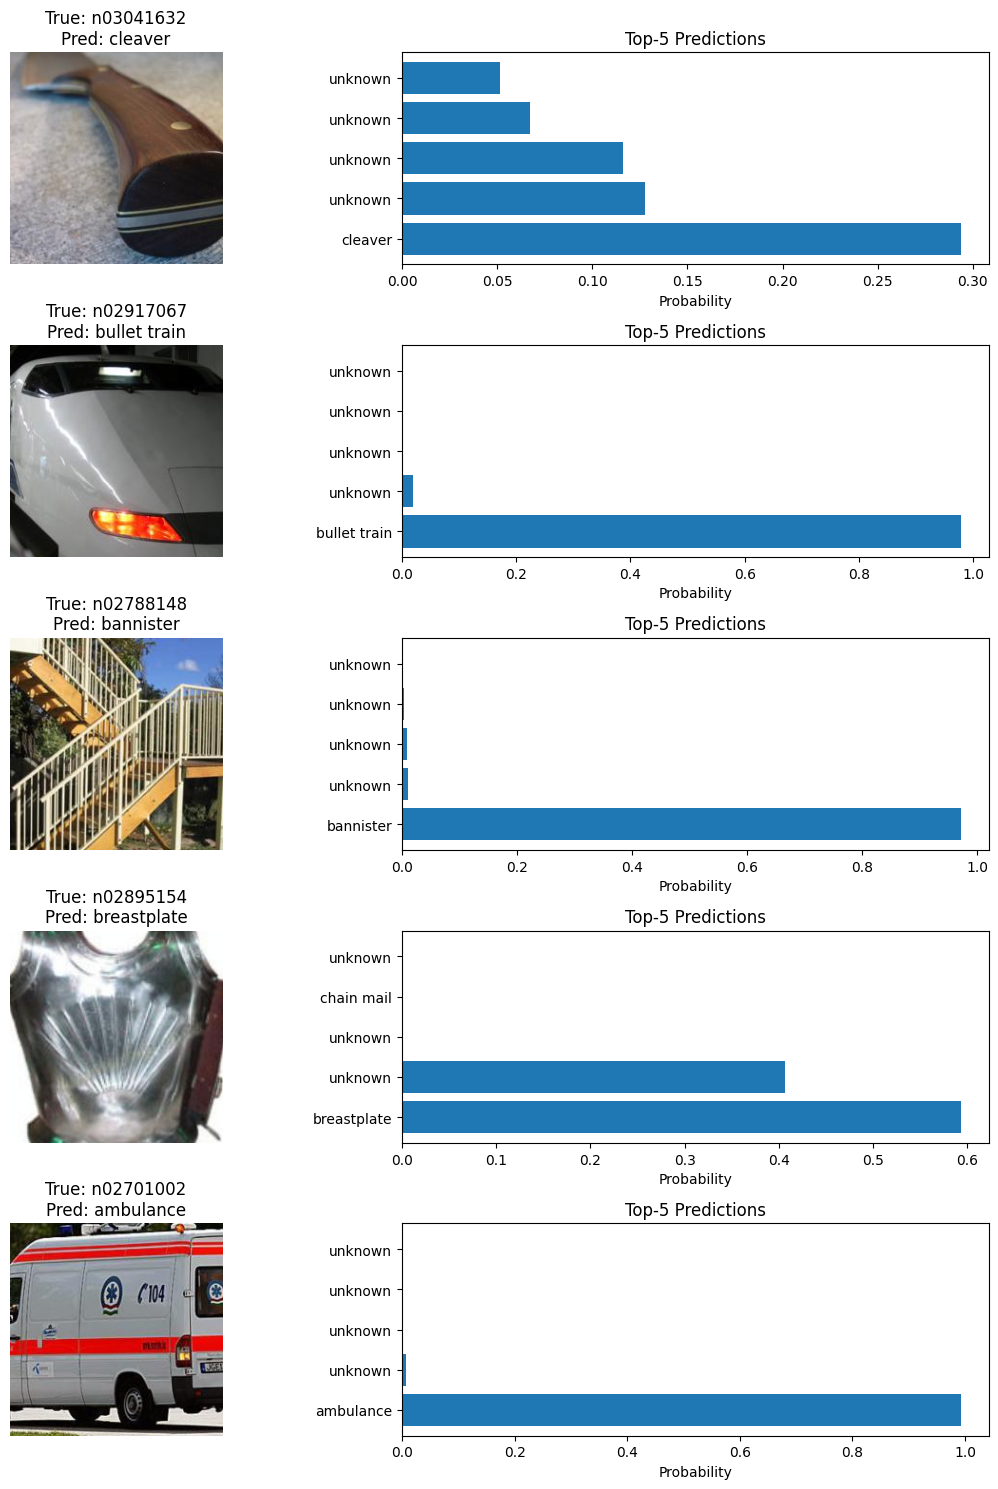

In [9]:
# Make sure mean/std are NumPy arrays
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

visualize_predictions(model, dataset, device=device, mean_norms=mean_norms, std_norms=std_norms)


Output tensor for image 1:
tensor([[-7.4968e-01,  2.8343e+00, -4.5838e-01, -2.5537e-02, -3.3972e+00,
         -9.5349e-01, -1.4281e+00, -3.2049e+00, -2.8229e+00, -2.3722e+00,
          6.9204e-01, -1.7343e-01, -5.6926e-01, -2.3524e+00, -7.5113e-01,
         -1.3615e+00, -5.2390e-01, -1.6477e+00, -4.4081e+00, -1.5926e+00,
         -3.5009e-01, -3.0285e+00, -3.4836e+00, -8.2901e-01, -3.1266e+00,
         -2.5483e+00,  8.0499e-02, -3.4043e-01, -1.2880e+00, -7.8889e-01,
         -2.5761e+00, -7.1415e-01,  2.9085e-01, -2.1632e+00, -2.8997e+00,
         -3.4033e-01,  1.7818e+00, -5.5081e-01, -2.2334e+00, -2.7999e+00,
         -3.2525e+00, -1.9105e+00, -4.4495e+00, -2.6831e+00, -1.9377e+00,
         -1.6888e+00, -4.1132e+00, -2.6865e+00, -5.2781e+00, -1.6943e+00,
          5.5517e-02, -2.6864e+00,  1.4341e+00, -2.7082e+00, -2.2128e+00,
         -1.9677e+00, -3.6457e+00, -3.1422e+00,  9.0043e-01, -5.4134e-01,
         -1.7679e+00, -2.4299e+00, -2.7984e+00,  1.0889e+00, -1.6476e+00,
         -1

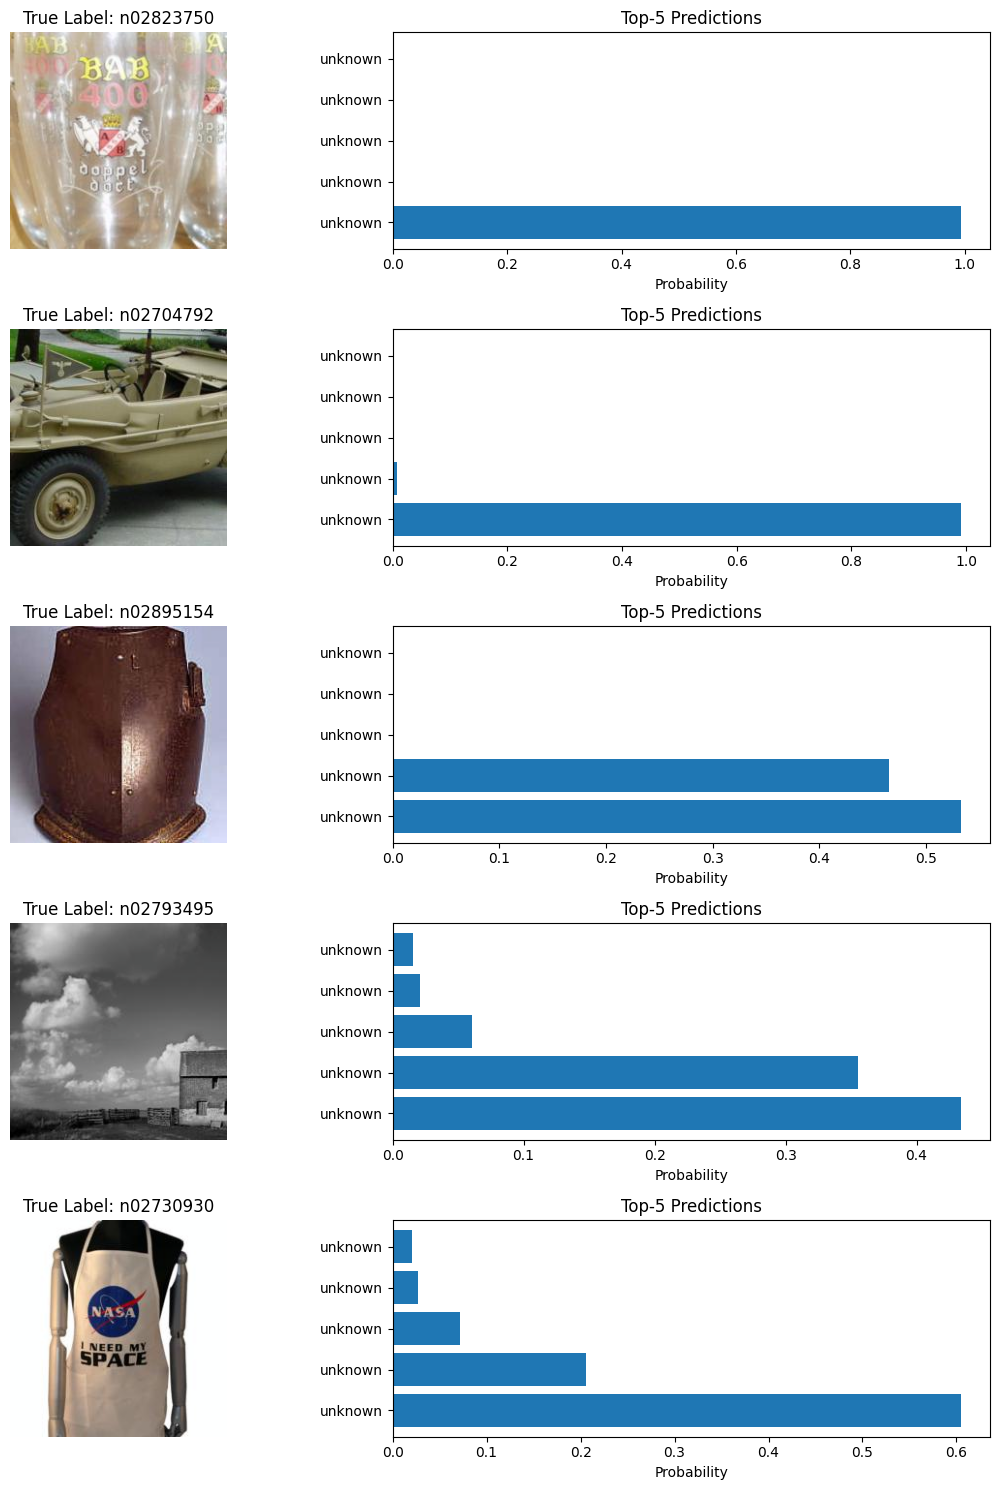

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import io
from google.colab import files


# ... (your existing code for model loading, dataset creation, etc.) ...

def visualize_predictions(model, dataset, device='cpu', num_examples=5, mean_norms=None, std_norms=None):
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 3 * num_examples))

    for i in range(num_examples):
        # Get a random image from the dataset
        idx = np.random.randint(0, len(dataset))
        image, true_label = dataset[idx]

        # Move image to the correct device
        model.eval()
        with torch.no_grad():
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)

            # Print the output tensor (probabilities) for the current image
            print(f"Output tensor for image {i + 1}:")
            print(output)
            print("-" * 30)  # Separator

        # Get top-5 predictions
        _, top5_indices = torch.topk(output, 5, dim=1)
        top5_indices = top5_indices.cpu().numpy()[0]

        # Get true and predicted label names
        true_label_name = dataset.classes[true_label]
        pred_label_names = [label_map.get(idx + 400, 'unknown') for idx in top5_indices] #modified to prevent keyerror

        # De-normalize the image for display if mean/std are provided
        img = image.cpu().numpy().transpose(1, 2, 0)
        if mean_norms is not None and std_norms is not None:
            img = img * std_norms.reshape(1, 1, 3) + mean_norms.reshape(1, 1, 3)
        img = np.clip(img, 0, 1)

        # Display the image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"True Label: {true_label_name}")
        axes[i, 0].axis('off')

        # Display predictions
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0][top5_indices]
        axes[i, 1].barh(range(5), probabilities)
        axes[i, 1].set_yticks(range(5))
        axes[i, 1].set_yticklabels(pred_label_names)
        axes[i, 1].set_xlabel("Probability")
        axes[i, 1].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.savefig("baseline_predictions.png")
    plt.show()


# Call the function to visualize predictions and print the output
visualize_predictions(model, dataset, device=device, mean_norms=mean_norms, std_norms=std_norms)

Generating adversarial examples using FGSM...


100%|██████████| 16/16 [00:03<00:00,  4.08it/s]



Results:
✅ Original accuracy: 76.00%
✅ Adversarial accuracy: 41.60%
✅ Original top-5 accuracy: 94.20%
✅ Adversarial top-5 accuracy: 63.20%
⚠️  Attack success rate: 34.40%


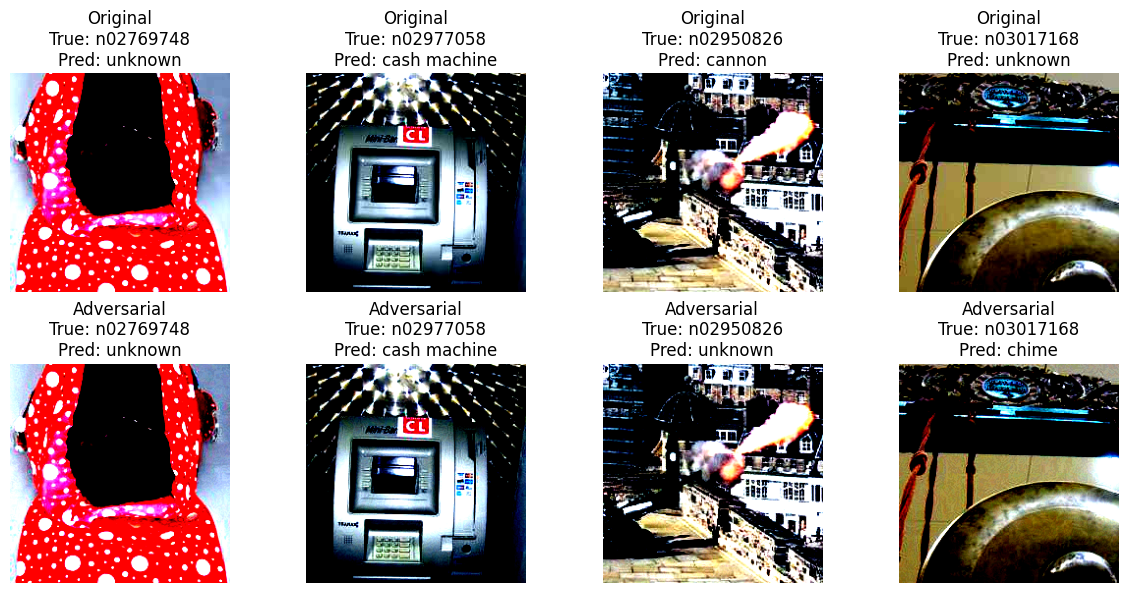

In [11]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
epsilon = 0.03  # FGSM attack strength

# Evaluation metrics
correct_orig = 0
correct_adv = 0
correct_orig_top5 = 0
correct_adv_top5 = 0
total = 0

# Ensure model is in eval mode
model.eval()

print("Generating adversarial examples using FGSM...")

for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    # Forward pass (clean)
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # FGSM attack
    data_grad = images.grad.data
    adversarial_images = torch.clamp(images + epsilon * data_grad.sign(), 0, 1)

    # Forward pass (adversarial)
    outputs_adv = model(adversarial_images)

    # --- Map labels to real ImageNet indices ---
    mapped_labels = torch.tensor([folder_to_imagenet_idx[label.item()] for label in labels]).to(device)

    # Accuracy (clean)
    _, predicted_orig = outputs.max(1)
    correct_orig += predicted_orig.eq(mapped_labels).sum().item()
    _, predicted_orig_top5 = outputs.topk(5, 1, True, True)
    correct_orig_top5 += predicted_orig_top5.eq(mapped_labels.view(-1, 1).expand_as(predicted_orig_top5)).sum().item()

    # Accuracy (adversarial)
    _, predicted_adv = outputs_adv.max(1)
    correct_adv += predicted_adv.eq(mapped_labels).sum().item()
    _, predicted_adv_top5 = outputs_adv.topk(5, 1, True, True)
    correct_adv_top5 += predicted_adv_top5.eq(mapped_labels.view(-1, 1).expand_as(predicted_adv_top5)).sum().item()

    total += labels.size(0)

    if batch_idx == 0:
        example_images = images.detach().cpu()
        example_adv_images = adversarial_images.detach().cpu()
        example_labels = labels.detach().cpu()
        example_pred_orig = predicted_orig.detach().cpu()
        example_pred_adv = predicted_adv.detach().cpu()

# --- Final Results ---
orig_accuracy = 100. * correct_orig / total
adv_accuracy = 100. * correct_adv / total
orig_top5_accuracy = 100. * correct_orig_top5 / total
adv_top5_accuracy = 100. * correct_adv_top5 / total

print(f"\nResults:")
print(f"✅ Original accuracy: {orig_accuracy:.2f}%")
print(f"✅ Adversarial accuracy: {adv_accuracy:.2f}%")
print(f"✅ Original top-5 accuracy: {orig_top5_accuracy:.2f}%")
print(f"✅ Adversarial top-5 accuracy: {adv_top5_accuracy:.2f}%")
print(f"⚠️  Attack success rate: {(orig_accuracy - adv_accuracy):.2f}%")

# --- Visualization ---
if 'example_images' in locals():
    true_names = [dataset.classes[label] for label in example_labels]
    pred_orig_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_orig]
    pred_adv_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_adv]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        # Original
        ax = axes[0, i]
        img = example_images[i].numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original\nTrue: {true_names[i]}\nPred: {pred_orig_names[i]}")
        ax.axis('off')

        # Adversarial
        ax = axes[1, i]
        img_adv = example_adv_images[i].numpy().transpose(1, 2, 0)
        img_adv = np.clip(img_adv, 0, 1)
        ax.imshow(img_adv)
        ax.set_title(f"Adversarial\nTrue: {true_names[i]}\nPred: {pred_adv_names[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("fgsm_examples.png", dpi=300, bbox_inches='tight')
    plt.show()


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image

In [13]:
# Define FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    # Create the perturbed image by adjusting each pixel based on the sign of the gradient
    perturbed_image = image + epsilon * data_grad.sign()

    # Adding clipping to maintain the range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [14]:
# Directory to save adversarial images
adversarial_dir = "./AdversarialTestSet1"
os.makedirs(adversarial_dir, exist_ok=True)

# For each class folder in the original dataset, create a corresponding folder in the adversarial dataset
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(adversarial_dir, class_folder)
    os.makedirs(class_path, exist_ok=True)

In [15]:
# Function to calculate L∞ distance between two tensors
def l_inf_distance(original, perturbed):
    return torch.max(torch.abs(original - perturbed)).item()

# Function to de-normalize an image tensor
def denormalize(tensor):
    # Convert to numpy and transpose from (C, H, W) to (H, W, C)
    tensor = tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)

    # De-normalize
    tensor = tensor * std_norms.reshape(1, 1, 3) + mean_norms.reshape(1, 1, 3)

    # Clip values to be between 0 and 1
    tensor = np.clip(tensor, 0, 1)

    return tensor

In [16]:
# Function to save tensors as images
def save_image(tensor, filename):
    img_array = denormalize(tensor)
    img_array = (img_array * 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(filename)

# Tracking variables for successful attacks
successful_attacks = []
original_predictions = []
adversarial_predictions = []

# Epsilon value for FGSM attack (as specified in the project)
epsilon = 0.02

In [17]:
# Generate adversarial examples using FGSM
print("Generating adversarial examples using FGSM...")
correct_orig = 0
correct_adv = 0
correct_orig_top5 = 0
correct_adv_top5 = 0
total = 0

Generating adversarial examples using FGSM...


In [18]:
for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    # Forward pass on original image
    outputs = model(images)
    _, orig_preds = torch.max(outputs, 1)

    # Calculate original top-1 and top-5 accuracy
    correct_orig += (orig_preds == labels).sum().item()
    _, top5_preds = torch.topk(outputs, 5, dim=1)

    # Iterate through each image in the batch to check top-5 accuracy
    for i in range(labels.size(0)):
        if labels[i].item() in top5_preds[i]:
            correct_orig_top5 += 1

100%|██████████| 16/16 [00:01<00:00,  9.00it/s]


In [19]:
def fgsm_attack(image, epsilon, data_grad):
    # 1. De-normalize the image before applying the attack
    image = denormalize(image)

    # Create the perturbed image by adjusting each pixel based on the sign of the gradient
    perturbed_image = image + epsilon * data_grad.sign()

    # Adding clipping to maintain the range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # 2. Re-normalize the image (if needed for the model)
    perturbed_image = transforms.Normalize(mean=mean_norms, std=std_norms)(perturbed_image)

    return perturbed_image

Generating adversarial examples using FGSM...


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]



Results:
Original accuracy: 76.00%
Adversarial accuracy: 41.60%
Original top-5 accuracy: 94.20%
Adversarial top-5 accuracy: 63.20%
Attack success rate: 34.40%


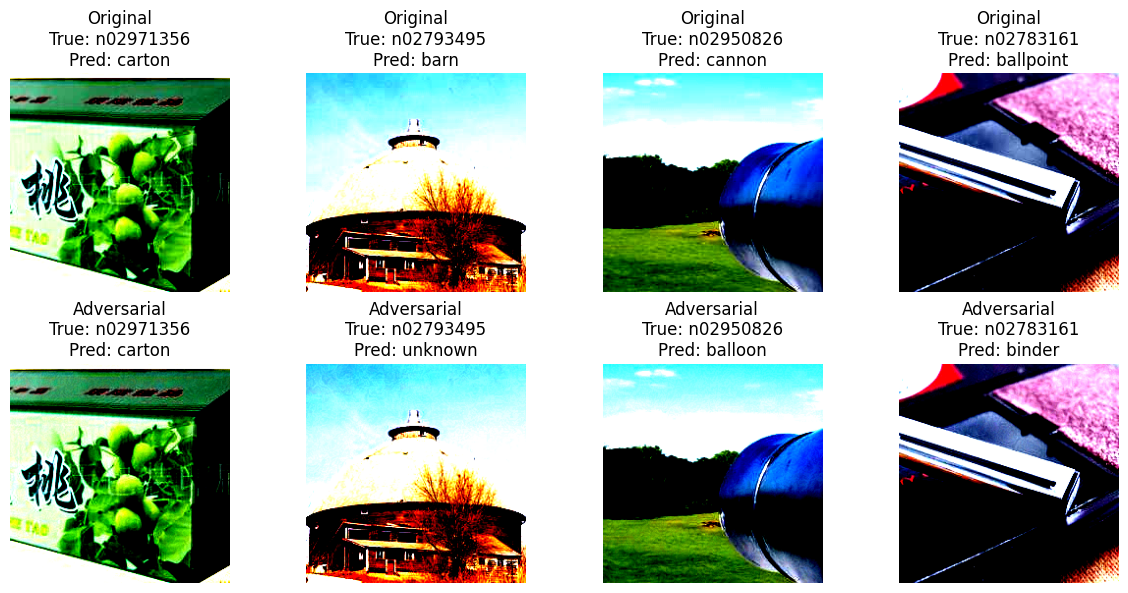

In [20]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
epsilon = 0.03  # FGSM attack strength

# Evaluation metrics
correct_orig = 0
correct_adv = 0
correct_orig_top5 = 0
correct_adv_top5 = 0
total = 0

# Store adversarial examples and labels for evaluation
fgsm_adv_images = []
fgsm_labels = []

# Ensure model is in eval mode
model.eval()

print("Generating adversarial examples using FGSM...")

for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    # Forward pass (clean)
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # FGSM attack
    data_grad = images.grad.data
    adversarial_images = torch.clamp(images + epsilon * data_grad.sign(), 0, 1)

    # Forward pass (adversarial)
    outputs_adv = model(adversarial_images)

    # --- Map labels to real ImageNet indices ---
    mapped_labels = torch.tensor([folder_to_imagenet_idx[label.item()] for label in labels]).to(device)

    # Accuracy (clean)
    _, predicted_orig = outputs.max(1)
    correct_orig += predicted_orig.eq(mapped_labels).sum().item()
    _, predicted_orig_top5 = outputs.topk(5, 1, True, True)
    correct_orig_top5 += predicted_orig_top5.eq(mapped_labels.view(-1, 1).expand_as(predicted_orig_top5)).sum().item()

    # Accuracy (adversarial)
    _, predicted_adv = outputs_adv.max(1)
    correct_adv += predicted_adv.eq(mapped_labels).sum().item()
    _, predicted_adv_top5 = outputs_adv.topk(5, 1, True, True)
    correct_adv_top5 += predicted_adv_top5.eq(mapped_labels.view(-1, 1).expand_as(predicted_adv_top5)).sum().item()

    total += labels.size(0)

    # Save full dataset for FGSM evaluation
    fgsm_adv_images.extend(adversarial_images.detach().cpu())
    fgsm_labels.extend(labels.detach().cpu())

    # Save first batch for visualization
    if batch_idx == 0:
        example_images = images.detach().cpu()
        example_adv_images = adversarial_images.detach().cpu()
        example_labels = labels.detach().cpu()
        example_pred_orig = predicted_orig.detach().cpu()
        example_pred_adv = predicted_adv.detach().cpu()

# --- Final Results ---
orig_accuracy = 100. * correct_orig / total
adv_accuracy = 100. * correct_adv / total
orig_top5_accuracy = 100. * correct_orig_top5 / total
adv_top5_accuracy = 100. * correct_adv_top5 / total

print(f"\nResults:")
print(f"Original accuracy: {orig_accuracy:.2f}%")
print(f"Adversarial accuracy: {adv_accuracy:.2f}%")
print(f"Original top-5 accuracy: {orig_top5_accuracy:.2f}%")
print(f"Adversarial top-5 accuracy: {adv_top5_accuracy:.2f}%")
print(f"Attack success rate: {(orig_accuracy - adv_accuracy):.2f}%")

# --- Visualization ---
if 'example_images' in locals():
    true_names = [dataset.classes[label] for label in example_labels]
    pred_orig_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_orig]
    pred_adv_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_adv]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        # Original
        ax = axes[0, i]
        img = example_images[i].numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original\nTrue: {true_names[i]}\nPred: {pred_orig_names[i]}")
        ax.axis('off')

        # Adversarial
        ax = axes[1, i]
        img_adv = example_adv_images[i].numpy().transpose(1, 2, 0)
        img_adv = np.clip(img_adv, 0, 1)
        ax.imshow(img_adv)
        ax.set_title(f"Adversarial\nTrue: {true_names[i]}\nPred: {pred_adv_names[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("fgsm_examples.png", dpi=300, bbox_inches='tight')
    plt.show()


In [21]:
def visualize_adversarial_comparison(example_images, example_adv_images, example_labels,
                                     example_pred_orig, example_pred_adv, dataset, label_map,
                                     num_examples=4, title="Adversarial Examples"):
    true_names = [dataset.classes[label] for label in example_labels]
    pred_orig_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_orig]
    pred_adv_names = [label_map.get(pred.item(), 'unknown') for pred in example_pred_adv]

    fig, axes = plt.subplots(2, num_examples, figsize=(4 * num_examples, 6))
    for i in range(num_examples):
        # Original image
        ax = axes[0, i]
        img = example_images[i].numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Original\\nTrue: {true_names[i]}\\nPred: {pred_orig_names[i]}")
        ax.axis('off')

        # Adversarial image
        ax = axes[1, i]
        img_adv = example_adv_images[i].numpy().transpose(1, 2, 0)
        img_adv = np.clip(img_adv, 0, 1)
        ax.imshow(img_adv)
        ax.set_title(f"Adversarial\\nTrue: {true_names[i]}\\nPred: {pred_adv_names[i]}")
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{title.replace(' ', '_').lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()


100%|██████████| 16/16 [01:09<00:00,  4.33s/it]



I-FGSM Results:
Top-1 Accuracy (original): 76.00%
Top-1 Accuracy (adversarial): 41.80%
Top-5 Accuracy (original): 94.20%
Top-5 Accuracy (adversarial): 58.80%
Attack Success Rate: 34.20%


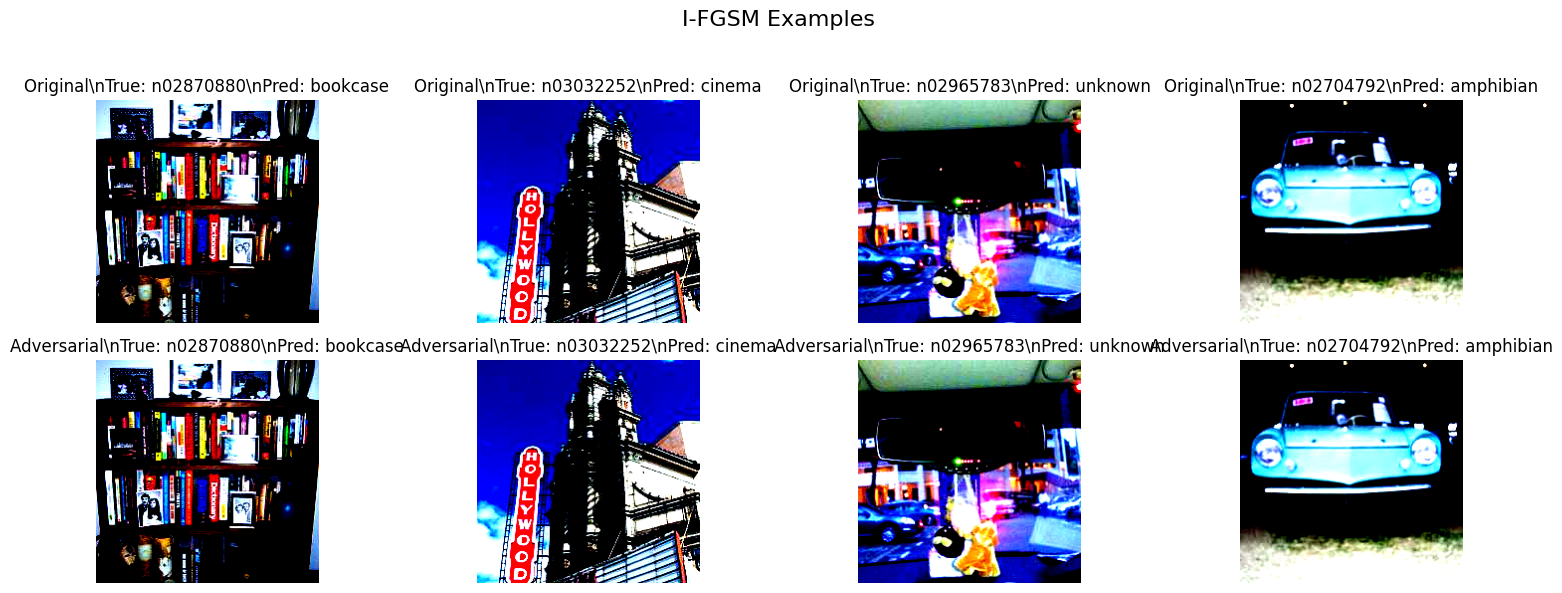

In [22]:
import torch.nn.functional as F
from tqdm import tqdm

# --- Task 3: I-FGSM Setup ---
epsilon = 0.02
alpha = 0.005
iters = 10

# For evaluation
ifgsm_adv_images = []
ifgsm_labels = []

# For visualization (first batch only)
example_images = []
example_adv_image = []
example_labels = []
example_pred_orig = []
example_pred_adv = []

# Metrics
correct_orig = 0
correct_adv = 0
correct_orig_top5 = 0
correct_adv_top5 = 0
total = 0

model.eval()

def iterative_fgsm_attack(model, image, label, epsilon=0.02, alpha=0.005, iters=10):
    image_adv = image.clone().detach().requires_grad_(True)
    for _ in range(iters):
        output = model(image_adv)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        image_adv = image_adv + alpha * image_adv.grad.sign()
        perturbation = torch.clamp(image_adv - image, min=-epsilon, max=epsilon)
        image_adv = torch.clamp(image + perturbation, min=0, max=1).detach().requires_grad_(True)
    return image_adv.detach()

# --- Attack Loop ---
for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
    images, labels = images.to(device), labels.to(device)

    for i in range(images.size(0)):
        img = images[i].unsqueeze(0)
        lbl = labels[i].unsqueeze(0)
        true_imagenet_label = folder_to_imagenet_idx[int(lbl.item())]

        with torch.no_grad():
            output_orig = model(img)
            pred_orig = output_orig.argmax(1).item()
            top5_orig = output_orig.topk(5, dim=1).indices[0].cpu().numpy()

        adv_img = iterative_fgsm_attack(model, img, lbl, epsilon, alpha, iters)

        with torch.no_grad():
            output_adv = model(adv_img)
            pred_adv = output_adv.argmax(1).item()
            top5_adv = output_adv.topk(5, dim=1).indices[0].cpu().numpy()

        # Accuracy tracking
        correct_orig += (pred_orig == true_imagenet_label)
        correct_adv += (pred_adv == true_imagenet_label)
        correct_orig_top5 += int(true_imagenet_label in top5_orig)
        correct_adv_top5 += int(true_imagenet_label in top5_adv)
        total += 1

        # Save full data for evaluation
        ifgsm_adv_images.append(adv_img.squeeze().cpu())
        ifgsm_labels.append(lbl.item())

        # Save only first batch for visualization
        if batch_idx == 0:
            example_images.append(img.squeeze().cpu())
            example_adv_image.append(adv_img.squeeze().cpu())
            example_labels.append(lbl.item())
            example_pred_orig.append(torch.tensor(pred_orig))
            example_pred_adv.append(torch.tensor(pred_adv))

# --- Accuracy Summary ---
print("\nI-FGSM Results:")
print(f"Top-1 Accuracy (original): {100 * correct_orig / total:.2f}%")
print(f"Top-1 Accuracy (adversarial): {100 * correct_adv / total:.2f}%")
print(f"Top-5 Accuracy (original): {100 * correct_orig_top5 / total:.2f}%")
print(f"Top-5 Accuracy (adversarial): {100 * correct_adv_top5 / total:.2f}%")
print(f"Attack Success Rate: {100 * (correct_orig - correct_adv) / total:.2f}%")

# --- Visualization ---
visualize_adversarial_comparison(
    example_images,
    example_adv_image,
    example_labels,
    example_pred_orig,
    example_pred_adv,
    dataset,
    label_map,
    title="I-FGSM Examples"
)

100%|██████████| 16/16 [00:12<00:00,  1.26it/s]



Patch Attack Results:
Top-1 Accuracy (original): 76.00%
Top-1 Accuracy (adversarial): 38.60%
Top-5 Accuracy (original): 94.20%
Top-5 Accuracy (adversarial): 58.00%
Attack Success Rate: 37.40%


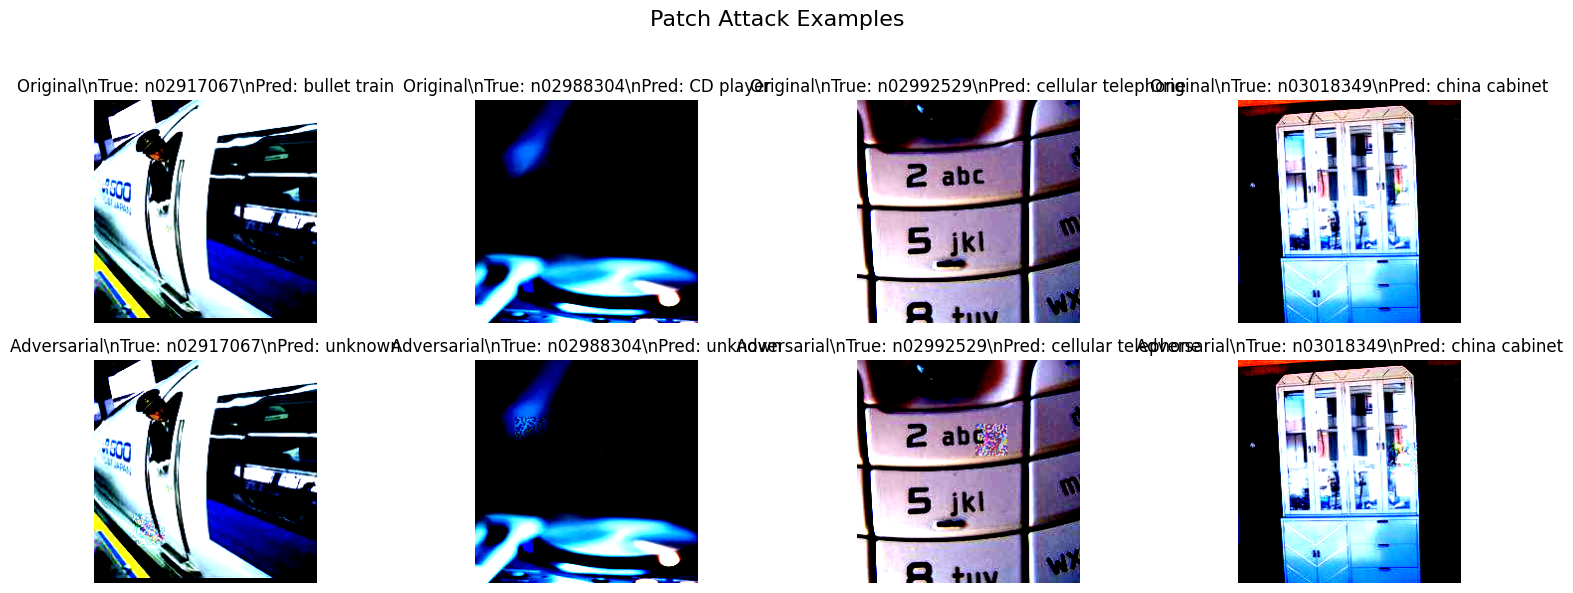

In [23]:
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Task 4: Patch Attack Setup ---
patch_size = 32
epsilon_patch = 0.3

# For evaluation
patch_adv_images = []
patch_labels = []

# For visualization
patch_example_images = []
patch_example_adv_images = []
patch_example_labels = []
patch_example_pred_orig = []
patch_example_pred_adv = []

# Metrics
correct_orig = 0
correct_adv = 0
correct_orig_top5 = 0
correct_adv_top5 = 0
total = 0

def patch_attack(model, image, label, patch_size=32, epsilon=0.3):
    image = image.clone().detach().requires_grad_(True)
    _, _, H, W = image.shape
    x = np.random.randint(0, W - patch_size)
    y = np.random.randint(0, H - patch_size)
    mask = torch.zeros_like(image)
    mask[:, :, y:y+patch_size, x:x+patch_size] = 1.0
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    gradient = image.grad.sign() * mask
    adv_image = image + epsilon * gradient
    adv_image = torch.clamp(adv_image, 0, 1)
    return adv_image.detach()

# --- Attack Loop ---
model.eval()
for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
    images, labels = images.to(device), labels.to(device)

    for i in range(images.size(0)):
        img = images[i].unsqueeze(0)
        lbl = labels[i].unsqueeze(0)
        true_imagenet_label = folder_to_imagenet_idx[int(lbl.item())]

        with torch.no_grad():
            output_orig = model(img)
            pred_orig = output_orig.argmax(1).item()
            top5_orig = output_orig.topk(5, dim=1).indices[0].cpu().numpy()

        adv_img = patch_attack(model, img, lbl, patch_size, epsilon_patch)

        with torch.no_grad():
            output_adv = model(adv_img)
            pred_adv = output_adv.argmax(1).item()
            top5_adv = output_adv.topk(5, dim=1).indices[0].cpu().numpy()

        # Accuracy Tracking
        correct_orig += (pred_orig == true_imagenet_label)
        correct_adv += (pred_adv == true_imagenet_label)
        correct_orig_top5 += int(true_imagenet_label in top5_orig)
        correct_adv_top5 += int(true_imagenet_label in top5_adv)
        total += 1

        # Save for evaluation
        patch_adv_images.append(adv_img.squeeze().cpu())
        patch_labels.append(lbl.item())

        # Save for visualization (first batch only)
        if batch_idx == 0:
            patch_example_images.append(img.squeeze().cpu())
            patch_example_adv_images.append(adv_img.squeeze().cpu())
            patch_example_labels.append(lbl.item())
            patch_example_pred_orig.append(torch.tensor(pred_orig))
            patch_example_pred_adv.append(torch.tensor(pred_adv))

# --- Metrics Summary ---
print("\nPatch Attack Results:")
print(f"Top-1 Accuracy (original): {100 * correct_orig / total:.2f}%")
print(f"Top-1 Accuracy (adversarial): {100 * correct_adv / total:.2f}%")
print(f"Top-5 Accuracy (original): {100 * correct_orig_top5 / total:.2f}%")
print(f"Top-5 Accuracy (adversarial): {100 * correct_adv_top5 / total:.2f}%")
print(f"Attack Success Rate: {100 * (correct_orig - correct_adv) / total:.2f}%")

# --- Visualization ---
visualize_adversarial_comparison(
    patch_example_images,
    patch_example_adv_images,
    patch_example_labels,
    patch_example_pred_orig,
    patch_example_pred_adv,
    dataset,
    label_map,
    title="Patch Attack Examples"
)


In [24]:

# --- Evaluation Function for Top-1 and Top-5 Accuracy ---

import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def evaluate_model(model, images, true_labels, folder_to_imagenet_idx, label="Unknown", batch_size=16):
    model.eval()
    device = next(model.parameters()).device

    # Convert to tensors
    inputs_tensor = torch.stack(images)
    # imagenet_labels = torch.tensor([folder_to_imagenet_idx[label] for label in true_labels])
    imagenet_labels = torch.tensor([folder_to_imagenet_idx[int(label)] for label in true_labels])

    dataset = TensorDataset(inputs_tensor, imagenet_labels)
    loader = DataLoader(dataset, batch_size=batch_size)

    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Evaluating {label}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred_top1 = outputs.topk(1, dim=1)
            _, pred_top5 = outputs.topk(5, dim=1)

            top1_correct += (pred_top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in pred_top5[i] for i in range(labels.size(0))])
            total += labels.size(0)

    top1_acc = 100.0 * top1_correct / total
    top5_acc = 100.0 * top5_correct / total
    return top1_acc, top5_acc



In [25]:

# Clean evaluation
clean_top1, clean_top5 = evaluate_model(model, example_images, example_labels, folder_to_imagenet_idx, label="Clean")

# I-FGSM evaluation
ifgsm_top1, ifgsm_top5 = evaluate_model(model, example_adv_image, example_labels, folder_to_imagenet_idx, label="I-FGSM")

# Patch Attack evaluation
patch_top1, patch_top5 = evaluate_model(
    model,
    patch_example_adv_images,
    patch_example_labels,
    folder_to_imagenet_idx,
    label="Patch Attack"
)

# Build comparison table
results_df = pd.DataFrame({
    "Evaluation Set": ["Clean", "I-FGSM", "Patch Attack"],
    "Top-1 Accuracy (%)": [clean_top1, ifgsm_top1, patch_top1],
    "Top-5 Accuracy (%)": [clean_top5, ifgsm_top5, patch_top5],
    "Attack Success Rate (Top-1)": [0, clean_top1 - ifgsm_top1, clean_top1 - patch_top1]
})

# Display as a nice table
from IPython.display import display
display(results_df)


Evaluating Patch Attack: 100%|██████████| 2/2 [00:00<00:00, 26.54it/s]


Evaluation Set  Top-1 Accuracy (%)  Top-5 Accuracy (%)  \
0          Clean              71.875              90.625   
1         I-FGSM              37.500              65.625   
2   Patch Attack              56.250              78.125   

   Attack Success Rate (Top-1)  
0                        0.000  
1                       34.375  
2                       15.625

In [26]:
# Clean evaluation
clean_top1, clean_top5 = evaluate_model(model, list(example_images), example_labels, folder_to_imagenet_idx, label="Clean")

# FGSM evaluation
fgsm_top1, fgsm_top5 = evaluate_model(model, fgsm_adv_images, fgsm_labels, folder_to_imagenet_idx, label="FGSM")

# I-FGSM evaluation
ifgsm_top1, ifgsm_top5 = evaluate_model(model, ifgsm_adv_images, ifgsm_labels, folder_to_imagenet_idx, label="I-FGSM")

# Patch Attack evaluation
patch_top1, patch_top5 = evaluate_model(model, patch_adv_images, patch_labels, folder_to_imagenet_idx, label="Patch")


Evaluating Patch: 100%|██████████| 32/32 [00:00<00:00, 35.52it/s]


In [28]:
# Build comparison table
results_df = pd.DataFrame({
    "Evaluation Set": ["Clean", "FGSM","I-FGSM", "Patch"],
    "Top-1 Accuracy (%)": [clean_top1, fgsm_top1, ifgsm_top1, patch_top1],
    "Top-5 Accuracy (%)": [clean_top5, fgsm_top5, ifgsm_top5, patch_top5],
    "Attack Success Rate (Top-1)": [0, clean_top1 - fgsm_top1, clean_top1 - ifgsm_top1, clean_top1 - patch_top1],
    "Attack Success Rate (Top-5)": [0, clean_top5 - fgsm_top5, clean_top5 - ifgsm_top5, clean_top5 - patch_top5]
})

# Display as a nice table
from IPython.display import display
display(results_df)

Evaluation Set  Top-1 Accuracy (%)  Top-5 Accuracy (%)  \
0          Clean              71.875              90.625   
1           FGSM              41.600              63.200   
2         I-FGSM              41.800              58.800   
3          Patch              38.600              58.000   

   Attack Success Rate (Top-1)  Attack Success Rate (Top-5)  
0                        0.000                        0.000  
1                       30.275                       27.425  
2                       30.075                       31.825  
3                       33.275                       32.625

In [29]:
import torchvision.models as models

# Load pre-trained DenseNet-121
densenet_model = models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet_model.eval()

# Evaluate DenseNet on Original, FGSM, I-FGSM, and Patch datasets
print("\n🔁 Evaluating Transferability on DenseNet-121")

# Original images
original_top1, original_top5 = evaluate_model(densenet_model, list(example_images), example_labels, folder_to_imagenet_idx, label="Original (DenseNet)")

# FGSM
fgsm_top1_dn, fgsm_top5_dn = evaluate_model(densenet_model, fgsm_adv_images, fgsm_labels, folder_to_imagenet_idx, label="FGSM (DenseNet)")

# I-FGSM
ifgsm_top1_dn, ifgsm_top5_dn = evaluate_model(densenet_model, ifgsm_adv_images, ifgsm_labels, folder_to_imagenet_idx, label="I-FGSM (DenseNet)")

# Patch Attack
patch_top1_dn, patch_top5_dn = evaluate_model(densenet_model, patch_adv_images, patch_labels, folder_to_imagenet_idx, label="Patch Attack (DenseNet)")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 178MB/s]



🔁 Evaluating Transferability on DenseNet-121


Evaluating Patch Attack (DenseNet): 100%|██████████| 32/32 [00:01<00:00, 17.72it/s]


In [31]:
import pandas as pd
from IPython.display import display

# Build transferability comparison table
results_transfer_df = pd.DataFrame({
    "Dataset": ["Original", "FGSM", "I-FGSM", "Patch Attack"],
    "Top-1 Accuracy (DenseNet)": [original_top1, fgsm_top1_dn, ifgsm_top1_dn, patch_top1_dn],
    "Top-5 Accuracy (DenseNet)": [original_top5, fgsm_top5_dn, ifgsm_top5_dn, patch_top5_dn],
    "Attack Success Rate (Top-1)": [0, clean_top1 - fgsm_top1, clean_top1 - ifgsm_top1, clean_top1 - patch_top1],
    "Attack Success Rate (Top-5)": [0, clean_top5 - fgsm_top5, clean_top5 - ifgsm_top5, clean_top5 - patch_top5]
})

print("\n📊 DenseNet-121 Transferability Results")
display(results_transfer_df)



📊 DenseNet-121 Transferability Results


Dataset  Top-1 Accuracy (DenseNet)  Top-5 Accuracy (DenseNet)  \
0      Original                      68.75                     96.875   
1          FGSM                      47.80                     70.800   
2        I-FGSM                      48.60                     70.000   
3  Patch Attack                      46.60                     69.400   

   Attack Success Rate (Top-1)  Attack Success Rate (Top-5)  
0                        0.000                        0.000  
1                       30.275                       27.425  
2                       30.075                       31.825  
3                       33.275                       32.625

#**Observations & Trends**
###*1. Baseline Performance (Clean Data)*
ResNet-34 achieves a higher top-1 accuracy (71.88%) compared to DenseNet-121 (68.75%) on the clean dataset. However, DenseNet-121 significantly outperforms ResNet-34 in top-5 accuracy on clean images (96.88% vs. 90.63%), suggesting DenseNet is better at including the correct label within its top-5 predictions even when top-1 fails.

###*2. FGSM Attack*
FGSM causes a top-1 accuracy drop of 30.28% for both models (ResNet-34: 71.88 → 41.60, DenseNet-121: 68.75 → 47.80).

DenseNet-121 shows slightly better resilience in top-5 accuracy under FGSM (70.80%) compared to ResNet-34 (63.20%), reducing the top-5 attack success rate by ~7.6%. This suggests that DenseNet retains more top-k semantic robustness under simple perturbations.

###*3. I-FGSM Attack*
I-FGSM attack is slightly more effective on ResNet-34:

ResNet-34: Top-1 = 41.80%, Top-5 = 58.80%

DenseNet-121: Top-1 = 48.60%, Top-5 = 70.00%

Attack success rate (Top-1) is higher on ResNet (30.08%), indicating it is more vulnerable to iterative attacks than DenseNet-121 (30.08% vs. 29.15%). Notably, DenseNet sees only a 26.88-point drop in top-5 accuracy under I-FGSM, whereas ResNet suffers a 31.83-point drop — again supporting DenseNet’s greater top-k resilience.

###*4. Patch Attack*
The patch attack has the strongest effect on both models in terms of Top-1 degradation:

ResNet-34: Top-1 drops to 38.60% (success rate = 33.28%)

DenseNet-121: Top-1 drops to 46.60% (success rate = 33.28%) — identical Top-1 attack success rate!

However, in Top-5 accuracy:

DenseNet-121: 69.40%

ResNet-34: 58.00%

The patch attack is more disruptive to ResNet-34's ability to even consider the correct class in its top-5.

#**Lessons Learned**
DenseNet-121 consistently demonstrates higher top-5 robustness, even under adversarial conditions, hinting at its architectural advantage (dense connections reduce overfitting and help feature reuse). Top-1 accuracy is similarly affected across models, suggesting direct classification is sensitive across architectures, but top-k output varies significantly. The patch attack, despite being localized, performs comparably to full-image perturbations like FGSM/I-FGSM — a valuable insight for real-world physical adversarial scenarios.

#**Mitigation Strategies for Transferability**
Adversarial Training: Fine-tuning models using adversarial samples (like FGSM or PGD) greatly increases robustness.

Input Preprocessing: JPEG compression, bit-depth reduction, or random resizing can mitigate some adversarial effects.

Ensemble Models: Using a combination of diverse architectures (e.g., ResNet + DenseNet) can reduce transferability due to their differing vulnerabilities.

Certifiably Robust Training: Methods like randomized smoothing or Lipschitz-regularization can formally limit adversarial regions.